# EDA for Ingedients and Small Portion for Clustering

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/545_Group_Project/cleaned_data_DW_z_score.csv'
df_cleaned = pd.read_csv(file_path)

In [ ]:
df_cleaned.head(2)

product_name  \
0                     Peanuts   
1  Granola Cranberry And Acai   

                                    ingredients_text     serving_size  \
0  Peanuts, wheat flour, sugar, rice flour, tapio...  28 g (0.25 cup)   
1  Whole rolled oats, milled cane sugar, vegetabl...   55 g (0.5 cup)   

   additives_n                                          additives  \
0          0.0  [ peanuts ]  [ wheat-flour ]  [ flour ]  [ sug...   
1          0.0  [ whole-rolled-oats ]  [ rolled-oats ]  [ oats...   

  additives_en nutrition_grade_fr  energy_100g  fat_100g  saturated_fat_100g  \
0          NaN                  b       1941.0     17.86                0.00   
1          NaN                  c       1824.0     10.91                0.91   

   ...  proteins_100g  salt_100g  sodium_100g  vitamin_a_100g  vitamin_c_100g  \
0  ...          17.86      0.635         0.25             0.0             0.0   
1  ...           9.09      0.254         0.10             0.0             0.0   

   calcium_100g  iron_100g  organic_label  nutrition_score_100g  \
0         0.071    0.00129              0                   0.0   
1         0.036    0.00262              0                   6.0   

   nutrition_grade  
0                4  
1                3  

[2 rows x 25 columns]

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91466 entries, 0 to 91465
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_name          91466 non-null  object 
 1   ingredients_text      91466 non-null  object 
 2   serving_size          91466 non-null  object 
 3   additives_n           91466 non-null  float64
 4   additives             91461 non-null  object 
 5   additives_en          62159 non-null  object 
 6   nutrition_grade_fr    91466 non-null  object 
 7   energy_100g           91466 non-null  float64
 8   fat_100g              91466 non-null  float64
 9   saturated_fat_100g    91466 non-null  float64
 10  trans_fat_100g        91466 non-null  float64
 11  cholesterol_100g      91466 non-null  float64
 12  carbohydrates_100g    91466 non-null  float64
 13  sugars_100g           91466 non-null  float64
 14  fiber_100g            91466 non-null  float64
 15  proteins_100g      

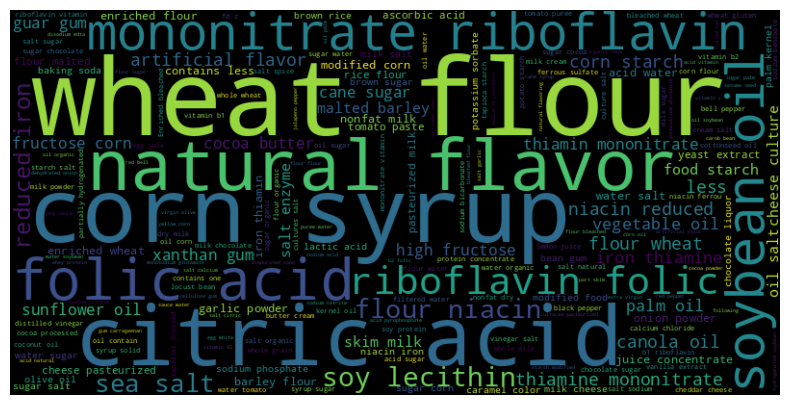

In [ ]:
from wordcloud import WordCloud
# column is not of string type so we need to make it is of string type
df_cleaned['ingredients_text'] = df_cleaned['ingredients_text'].astype(str)

# ''.join lets us make every entry into a giant string
all_ingredients = ' '.join(df_cleaned['ingredients_text'])

# background black to distringuish from other 2 datasets
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_ingredients)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') # bilinear smooths the pixels
plt.axis('off')
plt.show()

# This is really neat!
We can see that wheat flour, folic acid, citric acid, some oils, etc are used a lot in the dataset... but we are not seeing a lot of organic thrown in there which we will see later.

* While this is illustrating some intersecting ingredients in our dataset. It is still really difficult to understand especially since we have so much data and most of the data is skewed towards non organic foods

So I suggest looking at the dataset in two parts
1. Organic
2. Non-Organic

**But before we do this we need to address another issue.**  I want to show that the data still is not so clean.  In fact, we need to still do some cleaning just to get our data to a more usable form.

*See below results:*

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize) # prints whole text in array
unique_ingredients = df_cleaned['ingredients_text'].str.split(', ').explode().unique()
unique_ingredients # Inspect unique ingredients for manual verification

array(['Peanuts', 'wheat flour', 'sugar', 'rice flour', 'tapioca starch',
       'salt', 'leavening (ammonium bicarbonate', 'baking soda)',
       'soy sauce (water', 'soybeans', 'wheat', 'salt)', 'potato starch.',
       'Whole rolled oats', 'milled cane sugar',
       'vegetable oil (canola and/or safflower and/or sunflower oil)',
       'constarch', 'dried cranberries (cranberries', 'sunflower oil)',
       'natural flavor', 'barley malt syrup', 'acai berry.', 'honey',
       'coating (sucrose', 'wheat starch', 'maltodextrin', 'xanthan gum)',
       'non gmo canola oil', 'salt.', 'Cranberries', 'sunflower oil.',
       'Apricots', 'sulfur dioxide.', 'whole rolled wheat', 'coconut',
       'almonds', 'molasses', 'organic cardamon seed',
       'organic fennel seed', 'organic fenugreek seed', 'organic nu',
       'Dried mango', 'paprika', 'citric acid', 'and cayenne.',
       'Milk chocolate (sugar', 'cocoa butter', 'chocolate liquor',
       'whole milk powder', 'lactose', 'soy lecit

# **This is a lot to inspect...**

but we can see a lot of similar syntatical/clarical erroneous text data. This inspection took a ton of time, but I did really find any other way to fix this.  
Here are some notable ones that we can fix immediately with some regex (please note the letters are just placement holders):


*   x)
*   (x
*   *c
*   c*
*   [t
*   t]
*   {a
*   A}
*   s.
*   .s
*   a:
*   T_
*   _T
*   trailing and's
*   etc

Note: Some of the text could be nested like (pectin)] or salt)., we see that we have parenthesis and brackets.  We will address this in the next cell below...






In [ ]:
import re

# library to clean text with various patterns
import re

# regex to clean text with various patterns
def clean_complex_text(text):
    # removal of specific unwanted characters
    text = re.sub(r'[\*\[\]\{\}\:\_\(\)]', '', text)  # remove specified characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'\.\s*$', '', text) # remove trailing periods
    # Remove "and" at the end if it appears before another word
    text = re.sub(r'\s+and\b(?=\s+\w+)', '', text)
    text = text.lower()  # lowercase for uniformity
    text = text.strip()  # remove leading and trailing spaces
    return text

# apply the cleaning function
df_cleaned['cleaned_ingredients'] = df_cleaned['ingredients_text'].apply(clean_complex_text)


# Let's just take a quick peak at the first 100 elements to just make sure our data is looking better

Please note that there will still be some clarical discrepencies because the sheer nature of the large dataset, however this cleans up a lot.

And I wanted to keep things like

*   'and/or'
*   'contains 2%'

Stuff like this: the percent,the slash, etc, I want to keep as it is important.

In [ ]:
# Convert the 'cleaned_ingredients' column to a NumPy array
cleaned_ingredients_array = df_cleaned['cleaned_ingredients'].to_numpy() # Print the NumPy array to verify print(cleaned_ingredients_array)

In [ ]:
# quick peak
print(cleaned_ingredients_array[:100])

['peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening ammonium bicarbonate, baking soda, soy sauce water, soybeans, wheat, salt, potato starch'
 'whole rolled oats, milled cane sugar, vegetable oil canola and/or safflower and/or sunflower oil, rice flour, constarch, dried cranberries cranberries, sugar, sunflower oil, natural flavor, salt, barley malt syrup, acai berry'
 'peanuts, honey, coating sucrose, wheat starch, honey, maltodextrin, xanthan gum, non gmo canola oil, sugar, salt'
 'cranberries, sugar, sunflower oil' 'apricots, sulfur dioxide'
 'whole rolled oats, milled cane sugar, whole rolled wheat, vegetable oil canola and/or safflower and/or sunflower oil, coconut, honey, almonds, molasses, natural flavor, salt, organic cardamon seed, organic fennel seed, organic fenugreek seed, organic nu'
 'dried mango, paprika, sugar, salt, citric acid, cayenne'
 'milk chocolate sugar, cocoa butter, chocolate liquor, whole milk powder, lactose, soy lecithin an emulsifier

# GREAT! The data is looking much better!
## Now we can section everything into Organic and Non Organic datasets!

In [ ]:
# Create a DataFrame for organic items
df_organic = df_cleaned[df_cleaned['organic_label'] == 1]

# Create a DataFrame for non-organic items
df_not_organic = df_cleaned[df_cleaned['organic_label'] == 0]

print("Organic DataFrame:")
df_organic.head(3)


Organic DataFrame:


product_name  \
5                      Granola Honey Almonds   
31  Organic Flourless Sprouted 7-Grain Bread   
57              Ryan's, Organic Juice, Apple   

                                     ingredients_text      serving_size  \
5   Whole rolled oats, milled cane sugar, whole ro...    55 g (0.5 cup)   
31  Organic sprouted wheat, filtered water, organi...     34 g (1.2 oz)   
57                          100% organic apple juice.  240 ml (8 fl oz)   

    additives_n                                          additives  \
5           0.0  [ whole-rolled-oats ]  [ rolled-oats ]  [ oats...   
31          0.0  [ organic-sprouted-wheat ]  [ sprouted-wheat ]...   
57          0.0  [ 100-organic-apple-juice ]  [ organic-apple-j...   

   additives_en nutrition_grade_fr  energy_100g  fat_100g  saturated_fat_100g  \
5           NaN                  b       1674.0     14.55                2.73   
31          NaN                  a        983.0      2.94                0.00   
57          NaN                  b        192.0      0.00                0.00   

    ...  salt_100g  sodium_100g  vitamin_a_100g  vitamin_c_100g  calcium_100g  \
5   ...    0.11430        0.045             0.0          0.0000         0.073   
31  ...    0.67310        0.265             0.0          0.0000         0.000   
57  ...    0.04318        0.017             0.0          0.0038         0.000   

    iron_100g  organic_label  nutrition_score_100g  nutrition_grade  \
5     0.00262              1                   0.0                4   
31    0.00318              1                  -6.0                5   
57    0.00000              1                   2.0                4   

                                  cleaned_ingredients  
5   whole rolled oats, milled cane sugar, whole ro...  
31  organic sprouted wheat, filtered water, organi...  
57                           100% organic apple juice  

[3 rows x 26 columns]

In [ ]:
print("Non-Organic DataFrame:")
df_not_organic.head(3)

Non-Organic DataFrame:


product_name  \
0                     Peanuts   
1  Granola Cranberry And Acai   
2         Peanuts, Mixed Nuts   

                                    ingredients_text     serving_size  \
0  Peanuts, wheat flour, sugar, rice flour, tapio...  28 g (0.25 cup)   
1  Whole rolled oats, milled cane sugar, vegetabl...   55 g (0.5 cup)   
2  Peanuts, honey, coating (sucrose, wheat starch...  28 g (0.25 cup)   

   additives_n                                          additives  \
0          0.0  [ peanuts ]  [ wheat-flour ]  [ flour ]  [ sug...   
1          0.0  [ whole-rolled-oats ]  [ rolled-oats ]  [ oats...   
2          1.0  [ peanuts ]  [ honey ]  [ coating ]  [ sucrose...   

         additives_en nutrition_grade_fr  energy_100g  fat_100g  \
0                 NaN                  b       1941.0     17.86   
1                 NaN                  c       1824.0     10.91   
2  E415 - Xanthan gum                  d       2389.0     42.86   

   saturated_fat_100g  ...  salt_100g  sodium_100g  vitamin_a_100g  \
0                0.00  ...    0.63500        0.250             0.0   
1                0.91  ...    0.25400        0.100             0.0   
2                7.14  ...    0.54356        0.214             0.0   

   vitamin_c_100g  calcium_100g  iron_100g  organic_label  \
0             0.0         0.071    0.00129              0   
1             0.0         0.036    0.00262              0   
2             0.0         0.071    0.00514              0   

   nutrition_score_100g  nutrition_grade  \
0                   0.0                4   
1                   6.0                3   
2                  14.0                2   

                                 cleaned_ingredients  
0  peanuts, wheat flour, sugar, rice flour, tapio...  
1  whole rolled oats, milled cane sugar, vegetabl...  
2  peanuts, honey, coating sucrose, wheat starch,...  

[3 rows x 26 columns]

# Now let's do the same wordcloud but with each dataset

# Let's Start With Organic Dataset

In [ ]:
type(unique_ingredients)

numpy.ndarray

<ipython-input-15-954bc7d121cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_organic['cleaned_ingredients'] = df_organic['cleaned_ingredients'].astype(str)


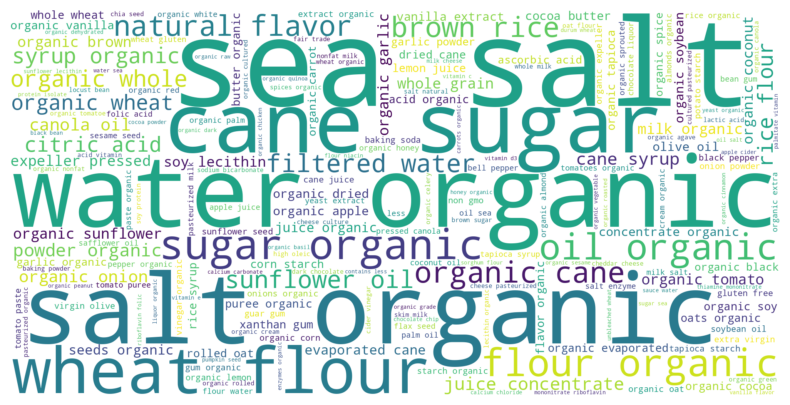

In [ ]:
# Ensure the column is of string type
df_organic['cleaned_ingredients'] = df_organic['cleaned_ingredients'].astype(str)

# Combine all text entries into a single string
all_ingredients = ' '.join(df_organic['cleaned_ingredients'])

# Generate the word cloud
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(all_ingredients)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# What we are seeing:

* Expected the salt variations, and lots of *organic* thrown around, cane sugar, canola oil (organic), etc

* This is telling me that a lot of organic products want to emphasis the word *organic* probably in their ingredients list since it's *Great Marketing*

* We can really just see organic splattered around, so I suspect when we do out Q-Grams (see below) analysis we will see lots of pairs with organic appended or prepended

What we can glean from this is that organic is emphasised in marketing so much so that consumers can see the word organic... this is important because a distringuishing feature is that organic foods probably will emphasis organic as a term.  Also we can see sugar isn't just sugar. We have vilanized the word sugar so by adding cane sugar, organic sugar, organic cane, syrup organic might be percieved as more "acceptable" and associated with "healthier" foods. In other words, marketing has figured out ways of avoiding just saying sugar.


# Not Organic Dataset

<ipython-input-16-68a21904c949>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_organic['cleaned_ingredients'] = df_not_organic['cleaned_ingredients'].astype(str)


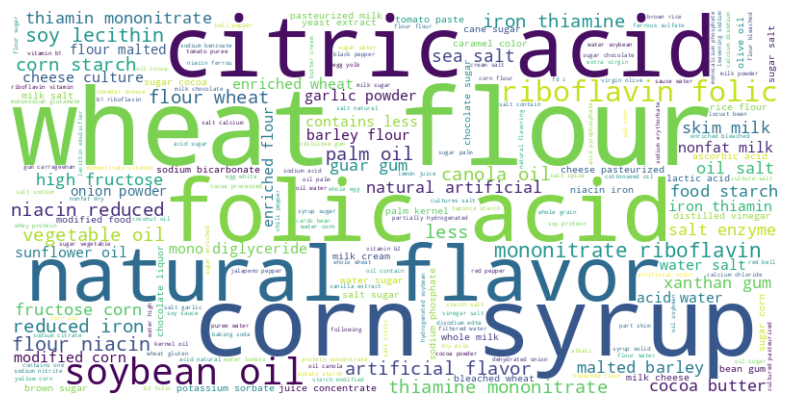

In [ ]:
# Ensure the column is of string type
df_not_organic['cleaned_ingredients'] = df_not_organic['cleaned_ingredients'].astype(str)

# Combine all text entries into a single string
all_ingredients = ' '.join(df_not_organic['cleaned_ingredients'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# What we are seeing:

* Above we can see the non organic products word cloud.  Oils, cyrup, folic acid, wheat flour, citric acid, natural flavor, etc

* don't see a single organic thrown in the cloud

* We will discuss further down below

# Let's take a look at the number of occurences of top ingredients



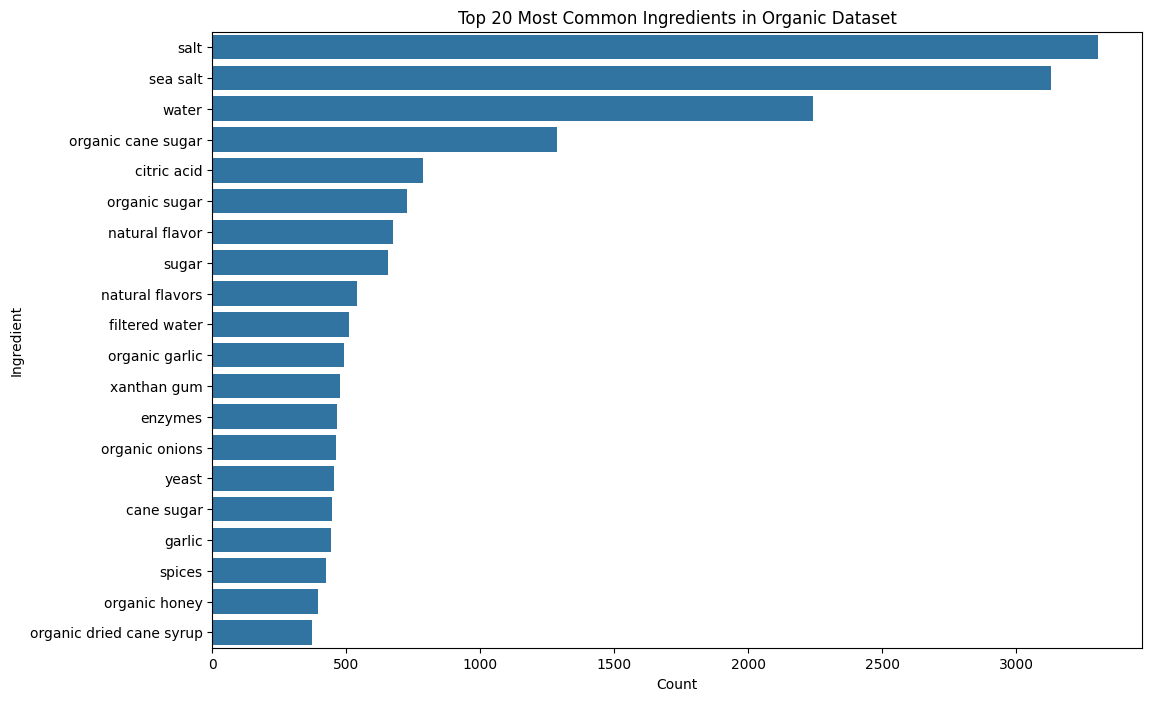

In [ ]:
from collections import Counter
import seaborn as sns

ingredients = ' '.join(df_organic['cleaned_ingredients']).split(', ')
ingredient_counts = Counter(ingredients)

ingredient_org_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count'])

# per count sort top 20
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Ingredient', data=ingredient_org_df.sort_values(by='Count', ascending=False).head(20))
plt.title('Top 20 Most Common Ingredients in Organic Dataset')
plt.show()

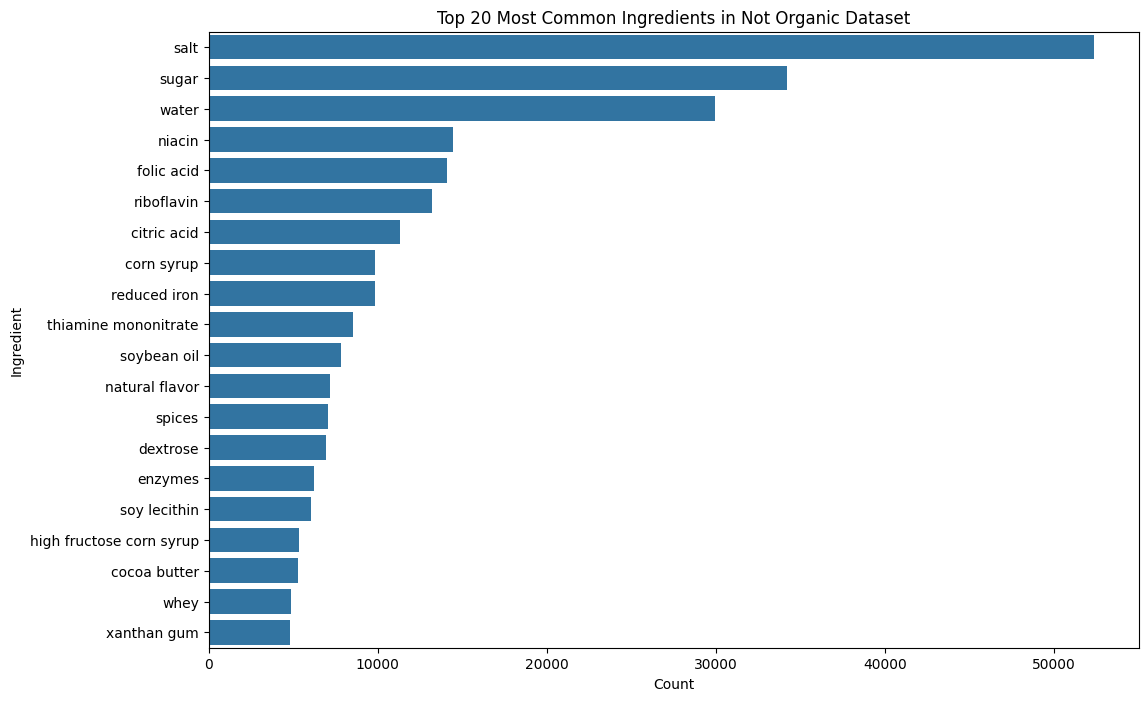

In [ ]:
from collections import Counter
import seaborn as sns

ingredients = ' '.join(df_not_organic['cleaned_ingredients']).split(', ')
ingredient_counts = Counter(ingredients)

# Convert to DataFrame for plotting
ingredient_not_org_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Ingredient', data=ingredient_not_org_df.sort_values(by='Count', ascending=False).head(20))
plt.title('Top 20 Most Common Ingredients in Not Organic Dataset')
plt.show()

# What we see:

We can clearly see the top 20 ingredients in the organic and non organic datasets.  I will not list them, but you can see above in the graphs.  Something to notice is there is some overlap in the data as well:

* wheat flour, salt, water of course, sugar, xantham gum (a binder), etc.

**This is great, but let's see it on a graph just to get a clearer idea of what is the most frequent ingredients per dataset**

# Another way to look at it if you do not want it in bar graph form

In [ ]:
ingredient_not_org_df.sort_values(by='Count', ascending=False).head(20)

Ingredient  Count
5                        salt  52362
2                       sugar  34188
59                      water  29935
39                     niacin  14453
43                 folic acid  14093
42                 riboflavin  13203
30                citric acid  11344
130                corn syrup   9843
40               reduced iron   9836
41       thiamine mononitrate   8512
58                soybean oil   7824
17             natural flavor   7172
172                    spices   7091
122                  dextrose   6947
69                    enzymes   6234
97               soy lecithin   6080
396  high fructose corn syrup   5337
32               cocoa butter   5300
443                      whey   4879
24                xanthan gum   4834

In [ ]:
ingredient_org_df.sort_values(by='Count', ascending=False).head(20)

Ingredient  Count
9                        salt   3306
29                   sea salt   3130
133                     water   2241
171        organic cane sugar   1285
30                citric acid    788
122             organic sugar    728
8              natural flavor    674
132                     sugar    656
273           natural flavors    542
14             filtered water    512
206            organic garlic    491
85                xanthan gum    478
63                    enzymes    465
198            organic onions    460
22                      yeast    453
547                cane sugar    447
182                    garlic    442
755                    spices    426
65              organic honey    393
56   organic dried cane syrup    374


# Insights and Analysis for EDA of top ingredients of organic and non-organic datasets.
Here are my observations (trying to be as unbiased as possible)

1. Common Ingredients:

  Both datasets contain some common ingredients i.e. salt, sugar, water, citric acid, natural flavor, enzymes, xantham gum, and spices. What this illustrates is that these ingredients are just widely used regardless of if a product is organic or not.

2. Distinct Ingredients:
  * Non-Organic Dataset:

  Contains ingredients often associated with processed foods, such as corn syrup, reduced iron, thiamine mononitrate (B1 Vit usually added in processed foods like crackers), soybean oil, dextrose, high fructose corn syrup, and various vitamins (e.g., folic acid, niacin, riboflavin).

  Ingredients like high fructose corn syrup and soy lecithin indicates a tendency towards additives and preservatives commonly found in processed foods. This adds "foritfication" or "shelf-life" to foods.

  * Organic Dataset:

  Emphasizes organic and natural sources, such as organic cane sugar, organic garlic, organic onions, organic honey, and organic dried cane syrup.

  Ingredients like sea salt, filtered water, and multiple forms of organic sugar highlight a focus on natural and minimally processed components.  Probably good marketing

  The repetition of terms like "organic" and "natural" underscores a marketing emphasis on organic certification and natural sourcing.

3. Health Implications: Again, trying to be unbiased
  * Non-Organic Dataset:

  The presence of folic acid, niacin, riboflavin, and reduced iron suggests fortification practices aimed at enhancing nutritional value.

  High levels of corn syrup and high fructose corn syrup could be linked to higher sugar content, which is often a concern regarding obesity and/or diabetes.

  * Organic Dataset:

  The use of organic cane sugar and organic honey (even organic sugar)highlights a preference for natural sweeteners.

  The inclusion of organic garlic, organic onions, and other organic vegetables points to a greater focus on whole food ingredients, which are "percieved" seen as healthier options.

4. Consumer Preferences:
  * Here I would highlight that there are a lot of factors driving people to buy organic and non organic foods, and that the point of this project is not to figure out what comsumers want.  However, I still think it is interesting to think about this in terms of ingredients.  Some consumers may not care about food being processed as much and therefore prioritize cost and availability over shelf life and additives.  On the flipside, organic products are marketed to comsumers probably prioritize health, environmental impacts, natural sourcing, and unneccessary ingredients that preserve the lifespan of food.  We can see the marketing strategy is heavy on the "organic" label.  This emphasis on the word "organic" is probably targeting heealth-conscious comsumers that are willing to pay a premium for quality of food...


This is awesome data!

In [ ]:
df_organic_exploded = df_organic['cleaned_ingredients'].str.split(', ').explode()
df_not_organic_exploded = df_not_organic['cleaned_ingredients'].str.split(', ').explode()

In [ ]:
df_organic_exploded.info()

<class 'pandas.core.series.Series'>
Index: 112721 entries, 5 to 91465
Series name: cleaned_ingredients
Non-Null Count   Dtype 
--------------   ----- 
112721 non-null  object
dtypes: object(1)
memory usage: 1.7+ MB


In [ ]:
type(df_not_organic_exploded)

pandas.core.series.Series

Exploring idea of grouping both non organic and organic datasets by ingredient, however even with pandas indexing this has to compare millions of rows.  We can just see from previous code that we have similar ingredients, so this was not truly neccessary for us to continue efforts with.  However, if someone in the future wants to pick this up I would suggest using Spark and whipping up a cluster.

```
# indexing faster join
df_new_org = df_organic_exploded.to_frame()
df_new_not_org = df_not_organic_exploded.to_frame()

df_new_org.set_index('cleaned_ingredients', inplace=True)
df_new_not_org.set_index('cleaned_ingredients', inplace=True)
# Perform the inner join on 'cleaned_ingredients'
common_ingredients = df_new_org.join(df_new_not_org, lsuffix='_organic', rsuffix='_not_organic', how='inner')

# reset index
common_ingredients.reset_index(inplace=True)

# occurrences of common ingredients
common_ingredient_counts = common_ingredients['cleaned_ingredients'].value_counts()

# Find the top 10 common ingredients
top_10_common_ingredients = common_ingredient_counts.head(10)

# Display the results
print("Top 10 Common Ingredients:\n", top_10_common_ingredients)
```

# Q-Grams/N-Grams:
**Here we will show that in the organic dataset there is so much emphasis on the organic label.  We will see down below in the output that with N = 2,3 organic is slapped on quite a bit, but in the non organic output it is not.**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Show to string type
df_organic['cleaned_ingredients'] = df_organic['cleaned_ingredients'].astype(str)

# Single string for every ingredient
all_ingredients = ' '.join(df_organic['cleaned_ingredients'])

# Function to generate n-grams
def generate_ngrams(corpus, ngram_range=(1, 1), num=None):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform([corpus])
    ngrams = vectorizer.get_feature_names_out()
    counts = X.toarray().sum(axis=0)
    ngram_counts = pd.DataFrame({'ngram': ngrams, 'count': counts})
    ngram_counts = ngram_counts.sort_values(by='count', ascending=False)

    if num:
        ngram_counts = ngram_counts.head(num)

    return ngram_counts

# bigrams
bigrams = generate_ngrams(all_ingredients, ngram_range=(2, 2), num=10)
print("Top 10 Bigrams:")
print(bigrams)

# trigrams
trigrams = generate_ngrams(all_ingredients, ngram_range=(3, 3), num=10)
print("\nTop 10 Trigrams:")
print(trigrams)

<ipython-input-24-69a61cff95fd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_organic['cleaned_ingredients'] = df_organic['cleaned_ingredients'].astype(str)


Top 10 Bigrams:
               ngram  count
24961       sea salt   4513
30466  water organic   3334
24590   salt organic   3288
3845      cane sugar   2733
30714    wheat flour   2170
27599  sugar organic   2162
10654  flour organic   2133
17895    oil organic   2065
18873   organic cane   1846
3281      brown rice   1706

Top 10 Trigrams:
                         ngram  count
63390         sea salt organic   2024
45871       organic cane sugar   1576
9294        cane sugar organic   1243
23178   filtered water organic    985
78537      wheat flour organic    875
45774       organic brown rice    780
50319      organic wheat flour    718
46979  organic evaporated cane    678
19921         dried cane syrup    647
9466        cane syrup organic    587


In [ ]:
# Ensure the column is of string type
df_not_organic['cleaned_ingredients'] = df_not_organic['cleaned_ingredients'].astype(str)

# Combine all text entries into a single string
all_ingredients = ' '.join(df_not_organic['cleaned_ingredients'])

# Function to generate n-grams
def generate_ngrams(corpus, ngram_range=(1, 1), num=None):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform([corpus])
    ngrams = vectorizer.get_feature_names_out()
    counts = X.toarray().sum(axis=0)
    ngram_counts = pd.DataFrame({'ngram': ngrams, 'count': counts})
    ngram_counts = ngram_counts.sort_values(by='count', ascending=False)

    if num:
        ngram_counts = ngram_counts.head(num)

    return ngram_counts

# Generate bigrams
bigrams = generate_ngrams(all_ingredients, ngram_range=(2, 2), num=10)
print("Top 10 Bigrams:")
print(bigrams)

# Generate trigrams
trigrams = generate_ngrams(all_ingredients, ngram_range=(3, 3), num=10)
print("\nTop 10 Trigrams:")
print(trigrams)

<ipython-input-25-46834929538a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_organic['cleaned_ingredients'] = df_not_organic['cleaned_ingredients'].astype(str)


Top 10 Bigrams:
                         ngram  count
132741             wheat flour  27219
32757               corn syrup  20730
52140               folic acid  16534
27109              citric acid  15972
114310             soybean oil  13219
103501        riboflavin folic  13157
77086   mononitrate riboflavin  12970
51529             flour niacin  12008
113914            soy lecithin  11782
102559            reduced iron  10129

Top 10 Trigrams:
                                  ngram  count
295065            riboflavin folic acid  13087
215734     mononitrate riboflavin folic  12524
146444                flour wheat flour   8951
222990              niacin reduced iron   8882
367804  thiamine mononitrate riboflavin   8516
144788             flour niacin reduced   8020
181403        iron thiamine mononitrate   7790
244831                       or less of   7621
87529                  contains or less   7449
393694               wheat flour niacin   6928


# This is just my attempt to learn about Word2Vec.  
This ended up not playing a super important role in our project, but more for me to learn about word2vec.  Here are some notable things I have learned and the code is below:

* Word2Vec is a machine learning technique that can find words with similar context and group them together, i.e. word similarity.

* In a sense, a 2-layer neural network processes the raw data in a high dimensional vector space.  Each word we can think of is a particular vector in this vector space.  

* Some challenges I faced early on was determinig whether to use a Continuous Bag of Words (CBOW) Model or a
Continuous Skip-Gram Model.  The CBOW Model takes (input) predicted word given context words, while Skip-Gram predicts
context word given focused/target word.  There are a few benefits and trade-offs of each mode, however the nuance
specific to our dataset is that CBOW tends to work better with frequently occuring words.  In this case with
ingredients we can make this as a very good assumption based on our findings above.

* Hence we will use the CBOW Architecture (in code (sg=0)). It defaults to this if not specified

* one important feature I'd like to highlight is that the meaurement/metric we are using is
Cosine Similarity

* Cosine similarity can be a technique that allows us to meaure how similar a word is contextually to another.
the values can be from [-1, 1]
where if we get a value of 1 then the vectors are pretty much the same (perfectly similar)
if we get a value of 0 then the vectors have no commonality (no similarity)
and if we get a value of -1 then they are completely dissimilar (oppsites)

* We can actually think of these results based on our understanding of linear algebra.
1. value = 1 --> vectors point in the same direction
2. value = 0 --> vectors are orthoganol! i.e. perpendicular
3. value = -1 --> vectors point in opposite directions

* Future: I thought that this would be a very neat way of showing in each dataset the words that tend to be similar to each other. I think that this does a great job illustrating our findings but to another degree.  But I also think this type of technique would be great for future tasks such as clustering and/or ML for classification of another problem.  For this specific project/problem this did not garner a lot of use.

In [ ]:
import nltk

# Download the 'punkt_tab' resource for sentence tokenization
nltk.download('punkt_tab')

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


# Tokenize the text
df_organic['tokenized_ingredients'] = df_organic['cleaned_ingredients'].apply(word_tokenize)

# Prepare the data for Word2Vec
sentences = df_organic['tokenized_ingredients'].tolist()

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model.save("word2vec.model")

# Load the model (optional, for later use)
model = Word2Vec.load("word2vec.model")

# Example: palm
word_vector = model.wv['palm']
print("Vector for 'Palm':", word_vector)

# Example salt
specific_word = "salt"
similar_words = model.wv.most_similar(specific_word, topn=5)

#print('{} has killed {} enemies'.format(agent_name,kill_count))
print("Words similar to {}: silimary word {}".format(specific_word, similar_words))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-26-fa354598983f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_organic['tokenized_ingredients'] = df_organic['cleaned_ingredients'].apply(word_tokenize)


Vector for 'Palm': [ 2.1981626  -0.13254413 -0.50309455  1.0800673   2.3428643  -1.51737
 -2.27618     1.0119184   0.72644514  0.3963587   0.11802639  0.8492701
  0.25537044  0.67887837  0.2531451  -1.2494688   0.08026177  1.2851231
  1.3228211   0.7941057   0.58490527  0.3613845  -0.33228615  2.3489354
 -0.03479715 -0.94566536 -0.66667324  1.3608388   1.6846402  -0.8114908
  0.53011703 -0.17597446  1.5692074  -0.43088704 -0.7017539   1.7356621
 -0.33981258 -2.09235    -0.39366266 -0.9282506   0.8588641   1.3041008
  0.4541283  -0.61211437 -0.13545103  0.7622331   0.05133036 -0.38812217
 -1.2124323  -0.95315856 -0.37903258 -0.86499757  0.93857896 -1.0612322
  1.5897107   0.05820221 -1.6008825   1.1264775   1.7289639  -2.338501
 -0.6892705   0.323535    1.8249187  -0.31809646 -0.77748585  1.6084545
  1.9912974  -1.0491464  -1.2965639   1.5021518  -1.4035206  -0.7198038
 -1.5905172   1.3224146   1.1400323   1.7170146  -0.3955054  -1.3720299
 -2.585149   -1.599304   -1.686649    0.6219848

# Now let's use Bert:


In [ ]:
from transformers import BertTokenizer, BertModel
#import torch

In [ ]:
# Load in Bert Dataset Pretrained uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # load tokenizer
model = BertModel.from_pretrained('bert-base-uncased') # load pre-trained model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# First Approach with BERT
The first way I was implementing it was actually training the ingredients data to get the [CLS] embeddings.  This require a lot of computational resources and took way too long.  I even used my Colab GPU resources, and I used up the limited resources without it finishing. Code Below:
```
# Load in Bert Dataset Pretrained uncased

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # load tokenizer
model = BertModel.from_pretrained('bert-base-uncased') # load pre-trained model

# Get Bert Embeddings from cleaned_ingredients
def get_cls_embeddings(text):
  with torch.no_grad():
    encoding = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    output = model(**encoding)
    last_hidden_state = output.last_hidden_state
    cls_embedding = last_hidden_state[:, 0, :].numpy()
    return cls_embedding

df_cleaned['CLS_embedding'] = df_cleaned['cleaned_ingredients'].apply(get_cls_embeddings)

# This code above was not used because it was using the CLS Embeddings and was training for hours.  It is a way to accomplish our task, but there is an easier way with just using the preloaded bert tokens
# which the code for that is below
```

# Second Approach to BERT (final way)
we are using a a pretrained tokenizer that BERT has provided to tokenize our ingredients list.  

```
in essence we are doing this:
sent = "hello my name is zachary yodh"
tz.tokenize(sent)
tz.convert_tokens_to_ids(tz.tokenize(sent))
```

And we will get some value i.e. [19082, 1139, 1271, 1110, 195, 7291, 3113, 26063, 17868]

We import necessary libraries for Bert Tokenization, but before we can even do that we need to clean the data even further.  We have already taken account for capitalization by lowercasing every word, but we also need to get rid of all punctuation and stop words (i.e. "and," "the," "is," "in," "at,", "on", etc).

This will improve preformance, improve efficiency from converting to token -> ids, and more importantly REDUCES NOISE!

In [ ]:
from transformers import BertTokenizer
tz = BertTokenizer.from_pretrained("bert-base-cased")
tz.convert_tokens_to_ids(["characteristically"])

sent = "She remains characteristically funny and cute."
tz.tokenize(sent)
tz.convert_tokens_to_ids(tz.tokenize(sent))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[1153, 2606, 7987, 2716, 6276, 1105, 10509, 119]

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
  # Don't need to worry about lowercase bc we already have done so
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  words = word_tokenize(text)
  words = [word for word in words if word not in stop_words]
  # Join words back into a single string
  cleaned_text = ' '.join(words)
  return cleaned_text

df_cleaned['cleaned_ingredients_new'] = df_cleaned['cleaned_ingredients'].apply(preprocess_text)

In [ ]:
df_cleaned.head()

product_name  \
0                     Peanuts   
1  Granola Cranberry And Acai   
2         Peanuts, Mixed Nuts   
3                 Cranberries   
4            Turkish Apricots   

                                    ingredients_text     serving_size  \
0  Peanuts, wheat flour, sugar, rice flour, tapio...  28 g (0.25 cup)   
1  Whole rolled oats, milled cane sugar, vegetabl...   55 g (0.5 cup)   
2  Peanuts, honey, coating (sucrose, wheat starch...  28 g (0.25 cup)   
3                 Cranberries, sugar, sunflower oil.  30 g (0.25 cup)   
4                          Apricots, sulfur dioxide.  40 g (7 PIECES)   

   additives_n                                          additives  \
0          0.0  [ peanuts ]  [ wheat-flour ]  [ flour ]  [ sug...   
1          0.0  [ whole-rolled-oats ]  [ rolled-oats ]  [ oats...   
2          1.0  [ peanuts ]  [ honey ]  [ coating ]  [ sucrose...   
3          0.0  [ cranberries ]  [ sugar ]  [ sunflower-oil ] ...   
4          1.0                   [ apricots ]  [ sulfur-dioxide ]   

             additives_en nutrition_grade_fr  energy_100g  fat_100g  \
0                     NaN                  b       1941.0     17.86   
1                     NaN                  c       1824.0     10.91   
2      E415 - Xanthan gum                  d       2389.0     42.86   
3                     NaN                  c       1255.0      0.00   
4  E220 - Sulphur dioxide                  c       1046.0      0.00   

   saturated_fat_100g  ...  sodium_100g  vitamin_a_100g  vitamin_c_100g  \
0                0.00  ...        0.250        0.000000             0.0   
1                0.91  ...        0.100        0.000000             0.0   
2                7.14  ...        0.214        0.000000             0.0   
3                0.00  ...        0.000        0.000000             0.0   
4                0.00  ...        0.000        0.001125             0.0   

   calcium_100g  iron_100g  organic_label  nutrition_score_100g  \
0         0.071    0.00129              0                   0.0   
1         0.036    0.00262              0                   6.0   
2         0.071    0.00514              0                  14.0   
3         0.000    0.00000              0                   8.0   
4         0.050    0.00360              0                   8.0   

   nutrition_grade                                cleaned_ingredients  \
0                4  peanuts, wheat flour, sugar, rice flour, tapio...   
1                3  whole rolled oats, milled cane sugar, vegetabl...   
2                2  peanuts, honey, coating sucrose, wheat starch,...   
3                3                  cranberries, sugar, sunflower oil   
4                3                           apricots, sulfur dioxide   

                             cleaned_ingredients_new  
0  peanuts wheat flour sugar rice flour tapioca s...  
1  whole rolled oats milled cane sugar vegetable ...  
2  peanuts honey coating sucrose wheat starch hon...  
3                    cranberries sugar sunflower oil  
4                            apricots sulfur dioxide  

[5 rows x 27 columns]

In [ ]:
def get_bert_tokens(ingredient_list):
  # we are not using the commented out code because this actually gives us other embeddings like CLS and SEP embeddings.  This is fine, but it not neccessary for our specific case
  # so to simplify this we just need to convert the ingredients list to tokens to ids.  This is also nice because now we do not need to clean up the [CLS] and [SEP] embeddings
  #tokenizer.encode(sentence, truncation=True, padding='max_length', max_length=512)
  encoded_input = tz.convert_tokens_to_ids(tz.tokenize(ingredient_list))
  return encoded_input

df_cleaned['tokenized_ingredients'] = df_cleaned['cleaned_ingredients_new'].apply(get_bert_tokens)

In [ ]:
df_cleaned.head()

product_name  \
0                     Peanuts   
1  Granola Cranberry And Acai   
2         Peanuts, Mixed Nuts   
3                 Cranberries   
4            Turkish Apricots   

                                    ingredients_text     serving_size  \
0  Peanuts, wheat flour, sugar, rice flour, tapio...  28 g (0.25 cup)   
1  Whole rolled oats, milled cane sugar, vegetabl...   55 g (0.5 cup)   
2  Peanuts, honey, coating (sucrose, wheat starch...  28 g (0.25 cup)   
3                 Cranberries, sugar, sunflower oil.  30 g (0.25 cup)   
4                          Apricots, sulfur dioxide.  40 g (7 PIECES)   

   additives_n                                          additives  \
0          0.0  [ peanuts ]  [ wheat-flour ]  [ flour ]  [ sug...   
1          0.0  [ whole-rolled-oats ]  [ rolled-oats ]  [ oats...   
2          1.0  [ peanuts ]  [ honey ]  [ coating ]  [ sucrose...   
3          0.0  [ cranberries ]  [ sugar ]  [ sunflower-oil ] ...   
4          1.0                   [ apricots ]  [ sulfur-dioxide ]   

             additives_en nutrition_grade_fr  energy_100g  fat_100g  \
0                     NaN                  b       1941.0     17.86   
1                     NaN                  c       1824.0     10.91   
2      E415 - Xanthan gum                  d       2389.0     42.86   
3                     NaN                  c       1255.0      0.00   
4  E220 - Sulphur dioxide                  c       1046.0      0.00   

   saturated_fat_100g  ...  vitamin_a_100g  vitamin_c_100g  calcium_100g  \
0                0.00  ...        0.000000             0.0         0.071   
1                0.91  ...        0.000000             0.0         0.036   
2                7.14  ...        0.000000             0.0         0.071   
3                0.00  ...        0.000000             0.0         0.000   
4                0.00  ...        0.001125             0.0         0.050   

   iron_100g  organic_label  nutrition_score_100g  nutrition_grade  \
0    0.00129              0                   0.0                4   
1    0.00262              0                   6.0                3   
2    0.00514              0                  14.0                2   
3    0.00000              0                   8.0                3   
4    0.00360              0                   8.0                3   

                                 cleaned_ingredients  \
0  peanuts, wheat flour, sugar, rice flour, tapio...   
1  whole rolled oats, milled cane sugar, vegetabl...   
2  peanuts, honey, coating sucrose, wheat starch,...   
3                  cranberries, sugar, sunflower oil   
4                           apricots, sulfur dioxide   

                             cleaned_ingredients_new  \
0  peanuts wheat flour sugar rice flour tapioca s...   
1  whole rolled oats milled cane sugar vegetable ...   
2  peanuts honey coating sucrose wheat starch hon...   
3                    cranberries sugar sunflower oil   
4                            apricots sulfur dioxide   

                               tokenized_ingredients  
0  [185, 23629, 1116, 11773, 15068, 6656, 7738, 1...  
1  [2006, 3733, 184, 9971, 6159, 1174, 14671, 665...  
2  [185, 23629, 1116, 8531, 20911, 28117, 1665, 1...  
3        [172, 4047, 22630, 6656, 3336, 15055, 2949]  
4             [170, 1643, 4907, 12129, 20450, 15163]  

[5 rows x 28 columns]

# This is Great! We have now tokenized each ingredient list per entry and assigned it an array of numerical values.  There are a few ways to approach this from here especially for modeling.  We can either pad each list like adding a buffer, and use that as a tensor for out input, or, more simplicitically, we can use the average/mean of each token vector for a singular value.  I am choosing the latter because it seems effective and adds simplicity to our large scoped project.

In [ ]:
df_cleaned['mean_embedding'] = df_cleaned['tokenized_ingredients'].apply(lambda x: np.mean(x, axis=0))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
df_cleaned['mean_embedding'].head()

0    7392.868421
1    6923.730769
2    7604.666667
3    7835.000000
4    9077.000000
Name: mean_embedding, dtype: float64

# Just taking a look to see if we got outputs

In [ ]:
df_cleaned[df_cleaned['organic_label'] == 1].head(20)

product_name  \
5                                Granola Honey Almonds   
31            Organic Flourless Sprouted 7-Grain Bread   
57                        Ryan's, Organic Juice, Apple   
72                          Yellow Corn Tortilla Chips   
74   Guiltless Gourmet, Organic Unsweetened Coconut...   
76                               Diced In Tomato Juice   
80                                           Tofu Firm   
91                                  Mochi, Cashew-Date   
108               Organic Nine Grain All Natural Bread   
109                           Organic 100% Whole Wheat   
110                                 Organic Great Seed   
111                                     Mountain White   
112                                   Great Seed Bread   
128                           Organic Tortellini Pasta   
129     Nuovo Pasta, Organic Ravioli, Butternut Squash   
130                                    Organic Ravioli   
162  Glaze Organic Sweeter & Thicker Balsamic Reduc...   
225                     Spaghetti sauce with mushrooms   
319       Get Back To Human, Crunchy Fig Chocolate Bar   
320          Golden Island, Korean Barbecue Pork Jerky   

                                      ingredients_text         serving_size  \
5    Whole rolled oats, milled cane sugar, whole ro...       55 g (0.5 cup)   
31   Organic sprouted wheat, filtered water, organi...        34 g (1.2 oz)   
57                           100% organic apple juice.     240 ml (8 fl oz)   
72   Stone ground organic yellow corn, expeller pre...          28 g (1 oz)   
74               Organic coconut water, ascorbic acid.  250 ml (8.45 fl oz)   
76   Organic tomatoes, organic tomato juice, sea sa...      130 g (0.5 cup)   
80   Water, organic whole soybeans, calcium sulfate...          79 g (79 g)   
91   Organic sweet brown rice, filtered water, date...        45 g (1.5 oz)   
108  Organic whole grain and seed blend (organic oa...          43 g (43 g)   
109  Ingredients: organic whole wheat flour, filter...       43 g (1 SLICE)   
110  Ingredients: organic whole grains (organic who...          43 g (43 g)   
111  Ingredients: water, brown rice flour, tapioca ...          36 g (36 g)   
112  Water, brown rice flour, tapioca starch, tapio...       40 g (1 SLICE)   
128  Filling: organic cheese blend (ricotta cheese,...        100 g (1 cup)   
129  Filling: organic butternut squash, organic ric...        100 g (1 cup)   
130  Filling: organic kale, organic white beans, or...        100 g (1 cup)   
162  Organic grape must, "aceto balsamico di modena...       15 ml (1 Tbsp)   
225  Organic tomato puree, organic diced tomatoes, ...       1/2 cup (116g)   
319  Cacao, organic coconut sugar, almonds, organic...          30 g (30 g)   
320  Pork , sugar, water, korean inspired seasoning...          28 g (1 oz)   

     additives_n                                          additives  \
5            0.0  [ whole-rolled-oats ]  [ rolled-oats ]  [ oats...   
31           0.0  [ organic-sprouted-wheat ]  [ sprouted-wheat ]...   
57           0.0  [ 100-organic-apple-juice ]  [ organic-apple-j...   
72           0.0  [ stone-ground-organic-yellow-corn ]  [ ground...   
74           1.0  [ organic-coconut-water ]  [ coconut-water ]  ...   
76           2.0  [ organic-tomatoes ]  [ tomatoes ]  [ organic-...   
80           2.0  [ water ]  [ organic-whole-soybeans ]  [ whole...   
91           0.0  [ organic-sweet-brown-rice ]  [ sweet-brown-ri...   
108          2.0  [ organic-whole-grain-and-seed-blend ]  [ whol...   
109          0.0  [ ingredients ]  [ organic-whole-wheat-flour ]...   
110          2.0  [ ingredients ]  [ organic-whole-grains ]  [ w...   
111          1.0  [ ingredients ]  [ water ]  [ brown-rice-flour...   
112          1.0  [ water ]  [ brown-rice-flour ]  [ rice-flour ...   
128          0.0  [ filling ]  [ organic-cheese-blend ]  [ chees...   
129          1.0  [ filling ]  [ organic-butternut-squash ]  [ b...   
130          0.0  [ filling

# Export to CSV

In [ ]:
# Take dataframe and save as new csv
pd.DataFrame.to_csv(df_cleaned, '/content/drive/MyDrive/Colab Notebooks/545_Group_Project/df_for_model.csv', index=False)

# Small Recap:
Our analysis reveals that organic products frequently emphasize the term "organic" in their ingredients lists, likely for marketing purposes. This emphasis helps consumers associate the products with health and quality. Common ingredients across both datasets include salt, sugar, water, citric acid, and natural flavors, indicating their widespread use.

Distinctly, non-organic products often contain processed food ingredients like corn syrup and various vitamins, indicating a focus on fortification and shelf-life. Organic products highlight natural and minimally processed ingredients like organic cane sugar and organic garlic, reflecting a marketing strategy that appeals to health-conscious consumers.

In terms of health implications, non-organic products may have higher sugar content due to ingredients like high fructose corn syrup, which is linked to obesity and diabetes concerns. In contrast, organic products use natural sweeteners and whole food ingredients, perceived as healthier options.

We hopefully will see Bert Tokenization for the ingredient mean embedding as a useful feature (see in modeling notebook)!